In [1]:
# Set environment
import warnings
warnings.filterwarnings('ignore')
rdst = 27

# Load libraries
import time
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

### Formulas

In [2]:
def dissimilarity(X, labels, k):

    '''
    Compute dissimilarity as defined by Birchfield–Tomasi (1998).

    Inputs:
    X - DataFrame containing observations.
    labels - Array of assigned clusters.
    k - Scalar defining number of clusters.

    Output:
    W_k - within cluster dissimilarity.
    '''
    
    W_k = 0
    
    for cluster in range(k):
        observations = X[labels == cluster]
        N_l = observations.shape[0]
        
        if N_l > 1:
            D_l = np.sum(pdist(observations, metric = 'euclidean') **2)
            W_k += D_l / (2 * N_l)

    return W_k

In [3]:
# Define class for Hierarchical model to use with Gap statistics
class HierarchicalModel:

    '''
    
    Uses scipy.cluster.hierarchy functions fcluster and linkage to perform hierarchical clustering.

    Z can be provided or will calculated using the given method.

    Adjustments:
    method - single, complete, average, weighted, centroid, median, ward
    criterion - inconsistent, distance, maxclust, monocrit, maxclust_monocrit
    
    '''
    
    def __init__(self, method = 'ward', criterion = 'maxclust', Z = None):
        self.method = method
        self.criterion = criterion
        self.Z = Z
        self.n_clusters = None

    def set_params(self, **params):
        self.n_clusters = params.get('n_clusters', self.n_clusters)
        # If Z not provided, compute it later from data in fit_predict

    def fit_predict(self, X):
        # Compute linkage if not already provided
        if self.Z is None:
            self.Z = linkage(X, method=self.method)
            
        return fcluster(self.Z, self.n_clusters, criterion = self.criterion) - 1

In [4]:
def gap_statistics(X, k_max, references = 20, random_state = None, model = None):

    '''
    
    Compute gap statistics of clustering method on data set vs simulated reference data.

    Inputs:
    X - DataFrame containing observations.
    k_max - Scalar defining max number of clusters to test.
    references - Scalar defining number of reference data to simulate.
    model - Clustering model to use. Model should take paramters n_clusters and method fit_predict.

    Output:
    log_W_k - log of within cluster dissimilarity of observations.
    expected_log_W_k - log of within cluster dissimilarity of simualted reference data.
    gaps - vector of differences in W_k between observations and simulated reference data.
    gap_diff - vector of difference in gaps between clusters.
    s_k_ref - standard deviations of W_k of simualted reference data.
    s_prime_k - standard error of k calculated from s_k_ref.
    
    '''

    if model is None:
        print ('Define clustering model for gap statistics.')
        return

    # Initiate parameters
    log_W_k = np.zeros(k_max - 1)
    expected_log_W_k = np.zeros(k_max - 1)
    gaps = np.zeros(k_max - 1)
    gap_diff = np.zeros(k_max - 2)
    s_k_ref = np.zeros(k_max - 1)
    
    for k in range(2, k_max + 1):
        # Set model paramters and fit to data
        model.set_params(n_clusters = k, random_state = random_state)
        labels = model.fit_predict(X)
        W_k = dissimilarity(X, labels, k)
        log_W_k[k - 2] = np.log(W_k)

        # Dissimilarities for reference data sets
        ref_W_k = np.zeros(references)
        
        for i in range(references):
            # Simulate reference datasets and fit model to each
            reference = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), size=X.shape)
            ref_labels = model.fit_predict(reference)
            ref_W_k[i] = dissimilarity(reference, ref_labels, k)

        # Expected log(W_k) is the mean of reference log dissimilarities
        expected_log_W_k[k - 2] = np.mean(np.log(ref_W_k))
        
        # Gaps are expected_log_W_k - log_W_k
        gaps[k - 2] = expected_log_W_k[k - 2] - log_W_k[k - 2]
        
        # Standard deviation of reference log dissimilarities
        s_k_ref[k - 2] = np.std(np.log(ref_W_k))
        
    for k in range(2, k_max):
        gap_diff[k - 2] = gaps[k - 1] - gaps[k - 2]
    
    s_prime_k = s_k_ref * np.sqrt(1 + 1 / references)
    
    return log_W_k, expected_log_W_k, gaps, gap_diff, s_k_ref, s_prime_k

## Data

### Loading

In [36]:
# Load data set
data = pd.read_csv("data/HR_data.csv")

# Separate depending on feature category
idx_data = data.iloc[:, 0]
eda_data = data.loc[:, data.columns.str.startswith("EDA")]
hr_data = data.loc[:, data.columns.str.startswith("HR")]
temp_data = data.loc[:, data.columns.str.startswith("TEMP")]
quest_data = data[['Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired', 'nervous', 'attentive', 'afraid', 'active', 'determined']]

KeyError: "None of [Index(['Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired',\n       'nervous', 'attentive', 'afraid', 'active', 'determined'],\n      dtype='object')] are in the [columns]"

<div class="alert alert-block alert-warning">
<b>To Do:</b> Define data set of choice.
</div>

In [ ]:
doc_data = eda_data
feat = doc_data.shape[1]

### Missing values

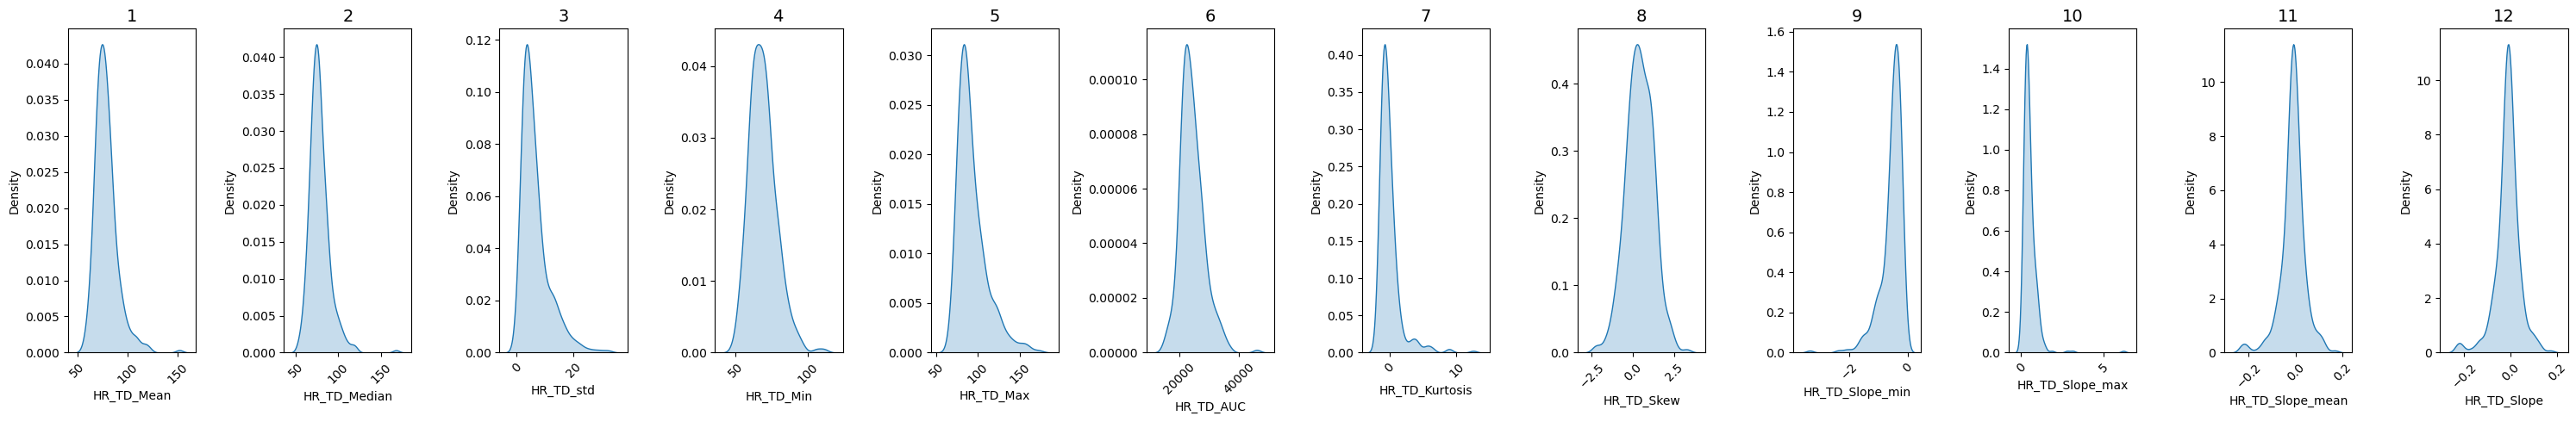

In [33]:
# Plot values and NaNs
fig, axes = plt.subplots(1, feat, figsize=(30, 5), sharey=False)
fig.subplots_adjust(wspace=0.5)

for col in range(feat):
    sn.kdeplot(doc_data.iloc[:, col], ax=axes[col], fill=True)
    axes[col].set_title(col+1, fontsize=14)
    axes[col].tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

In [34]:
# Locate NaNs
np.where(doc_data.isna() == True)

(array([], dtype=int64), array([], dtype=int64))

<div class="alert alert-block alert-warning">
<b>To Do:</b> Decide how to handle NaNs.
</div>

In [11]:
# Columns to remove
remove_cols = list([])

In [12]:
# Remove 'afraid' column
doc_data_cleaned = doc_data.drop(columns = remove_cols)

# Remove rows with remaining NaNs
nan_row_idx = np.where(doc_data_cleaned.isna() == True)[0]
idx_data_cleaned = idx_data.drop(np.unique(nan_row_idx))
doc_data_cleaned = doc_data_cleaned.drop(np.unique(nan_row_idx))

### Overview

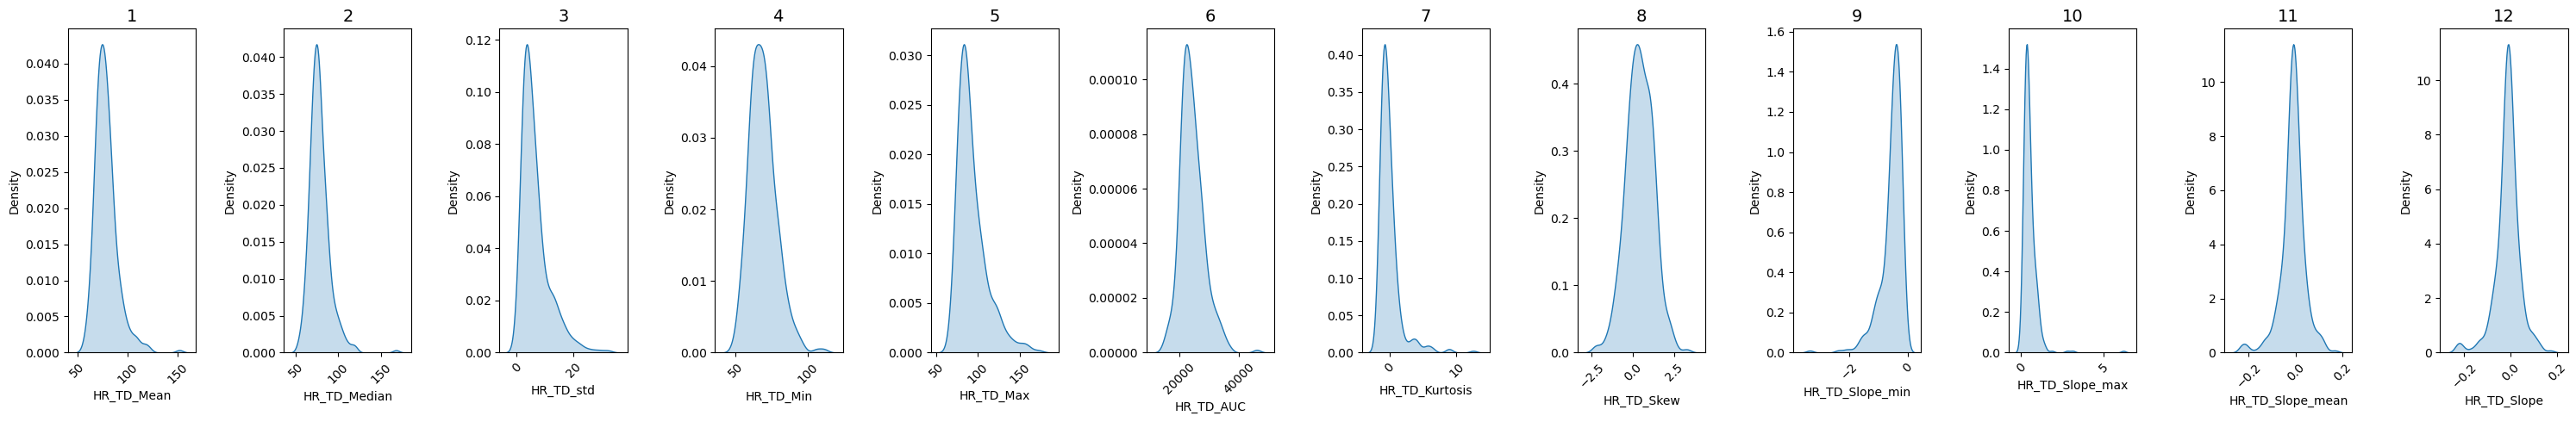

In [13]:
# Plot data distributions
feat = doc_data_cleaned.shape[1]
fig, axes = plt.subplots(1, feat, figsize=(30, 5), sharey=False)
fig.subplots_adjust(wspace=0.5)

for col in range(feat):
    sn.kdeplot(doc_data_cleaned.iloc[:, col], ax=axes[col], fill=True)
    axes[col].set_title(col+1, fontsize=14)
    axes[col].tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

In [14]:
# Normalize to range from 0 to 1
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(
    scaler.fit_transform(doc_data_cleaned),
    columns=doc_data_cleaned.columns,
    index=doc_data_cleaned.index)

In [15]:
# Define feature data
feature_columns = normalized_data.columns.values.tolist()
features = normalized_data[feature_columns]

In [16]:
# PCA for visualizing clusters
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
normalized_data['PCA1'] = pca_result[:, 0]
normalized_data['PCA2'] = pca_result[:, 1]

## Similarity

### Similarity

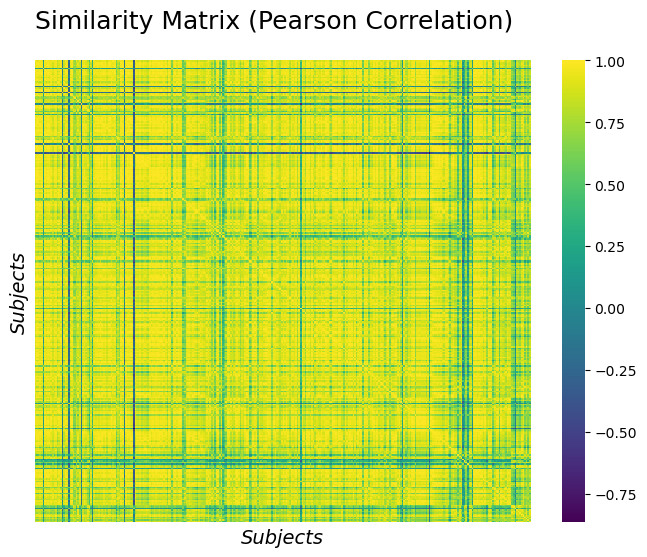

In [17]:
# Similarity matrix using Pearson correlation
similarity_matrix = features.T.corr()

# Heatmap
fig, ax = plt.subplots(figsize=(8, 6))

ax = sn.heatmap(similarity_matrix, cmap='viridis', annot=False)
ax.set_ylabel("Subjects", size = 14, fontstyle = 'italic')
ax.set_xlabel("Subjects", size = 14, fontstyle = 'italic')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Similarity Matrix (Pearson Correlation)', y=1.1, pad=-10, loc='left', size=18)

plt.show()

### Dissimilarity

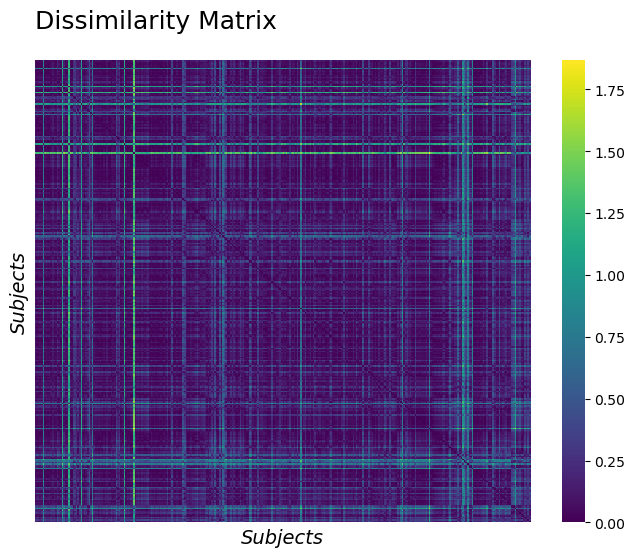

In [18]:
# Dissimilarity matrix
dissimilarity_matrix = 1 - similarity_matrix

# Heatmap
fig, ax = plt.subplots(figsize=(8, 6))

ax = sn.heatmap(dissimilarity_matrix, cmap='viridis', annot=False)
ax.set_ylabel("Subjects", size = 14, fontstyle = 'italic')
ax.set_xlabel("Subjects", size = 14, fontstyle = 'italic')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Dissimilarity Matrix', y=1.1, pad=-10, loc='left', size=18)

plt.show()

## K-means

### Silhouette

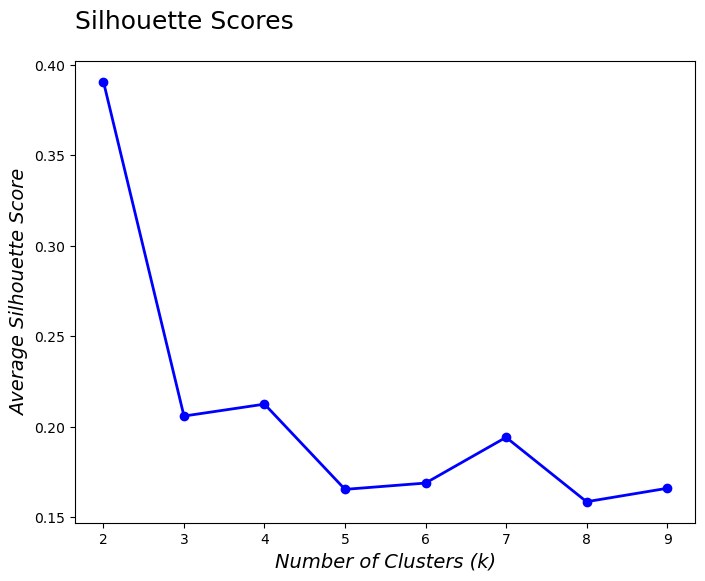

In [19]:
sil_scores = []
k_values = range(2, 10)

# Loop through k values
for k in k_values:
    model = KMeans(n_clusters=k, random_state=rdst)
    labels = model.fit_predict(features)
    score = silhouette_score(features, labels)
    sil_scores.append(score)

# Plot silhouette scores
fig, ax = plt.subplots(figsize=(8, 6))

ax = plt.plot(k_values, sil_scores, 'bo-', linewidth=2)
plt.ylabel("Average Silhouette Score", size = 14, fontstyle = 'italic')
plt.xlabel("Number of Clusters (k)", size = 14, fontstyle = 'italic')
plt.title('Silhouette Scores', y=1.1, pad=-10, loc='left', size=18)

plt.show()

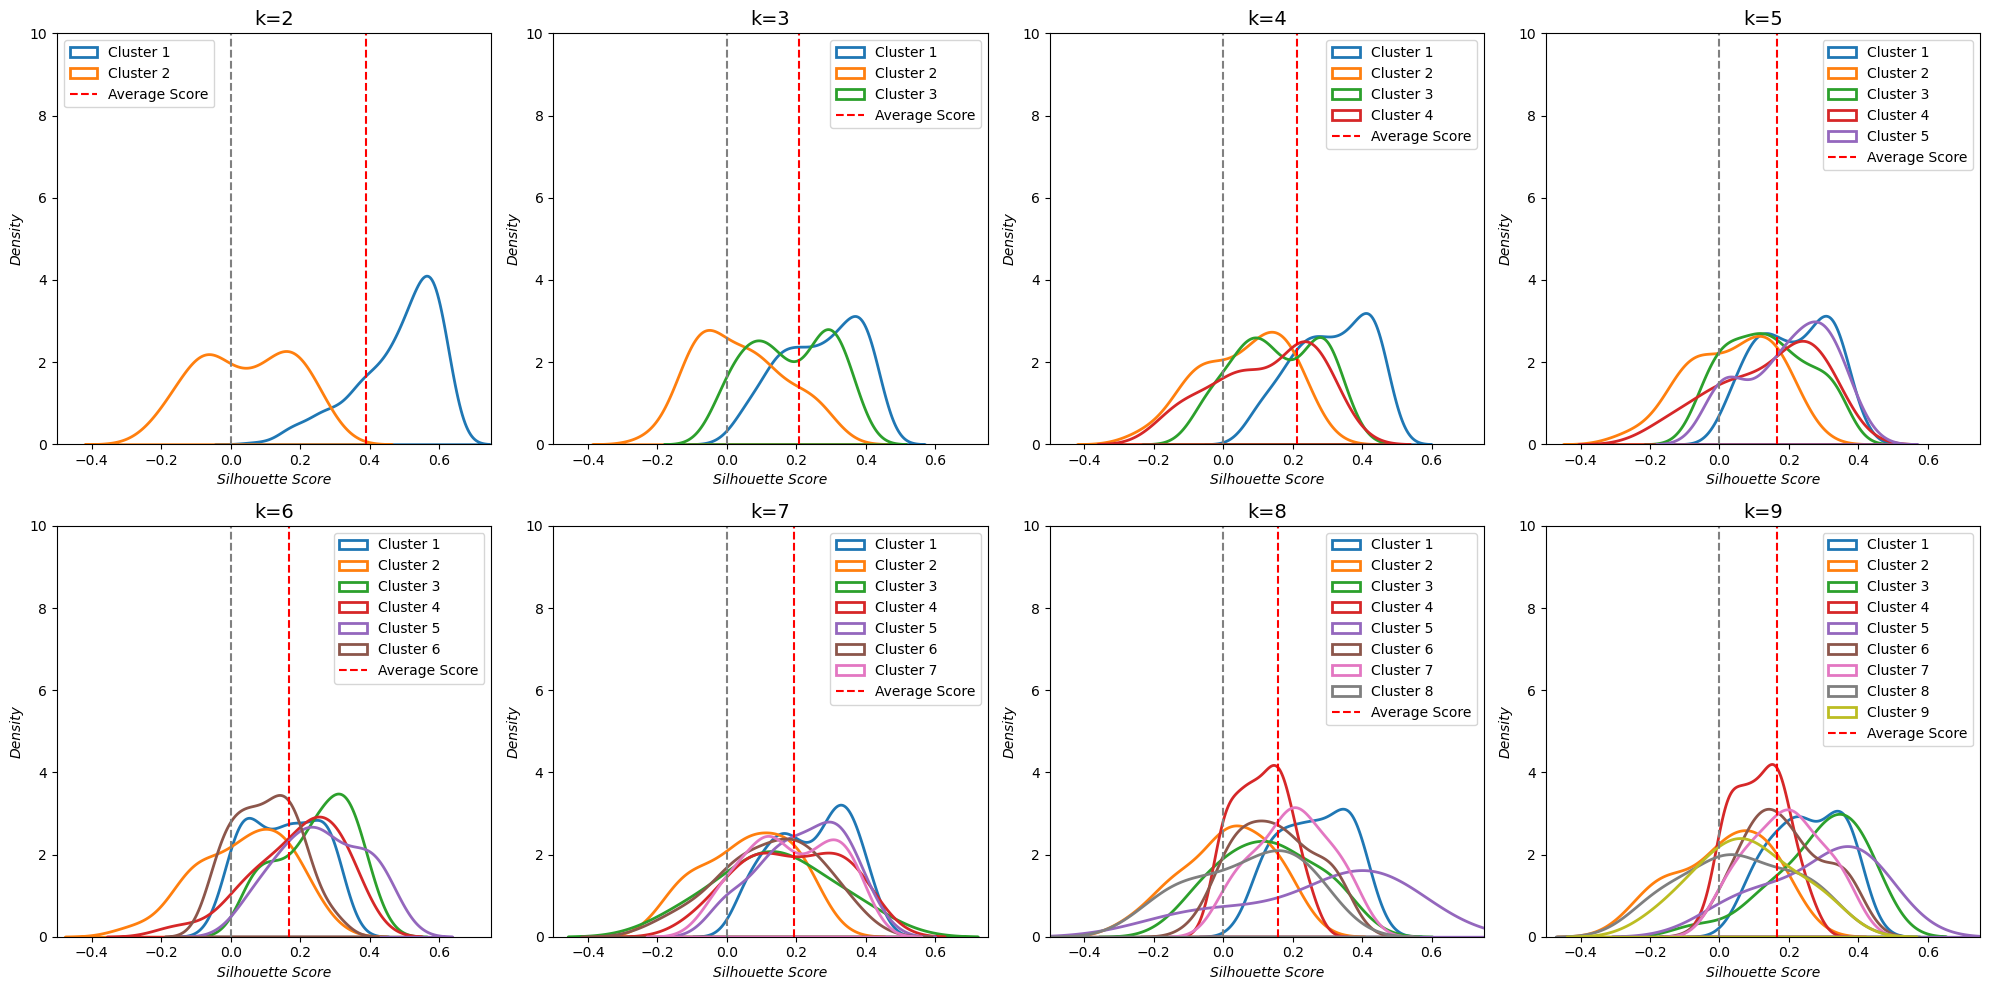

In [20]:
# Set up figure
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Loop through k values
for idx, k in enumerate(k_values):
    row, col = divmod(idx, 4)
    
    # Fit KMeans model for k
    model = KMeans(n_clusters=k, random_state=rdst)
    labels = model.fit_predict(features)
    
    # Calculate silhouette scores
    sil_scores = silhouette_samples(features, labels)
    
    ax = axes[row, col]
    
    # Create separate density plots for each cluster
    for i in range(k):
        cluster_sil_scores = sil_scores[labels == i]
        sn.kdeplot(cluster_sil_scores, ax = ax, shade = True, alpha = 0, lw = 2, label = f'Cluster {i+1}')
    
    # Add average silhouette score
    avg_score = silhouette_score(features, labels)
    ax.axvline(x = avg_score, color = 'red', linestyle = '--', label = 'Average Score')

    # Add silhouette score = 0
    ax.axvline(x = 0, color = 'grey', linestyle = '--')
    
    ax.set_title(f'k={k}', size = 14)
    ax.set_xlim(-0.5, 0.75)
    ax.set_ylim(0, 10)
    ax.set_xlabel('Silhouette Score', size = 10, fontstyle = 'italic')
    ax.set_ylabel('Density', size = 10, fontstyle = 'italic')
    ax.legend()

plt.tight_layout()
plt.show()

### Gap statistics

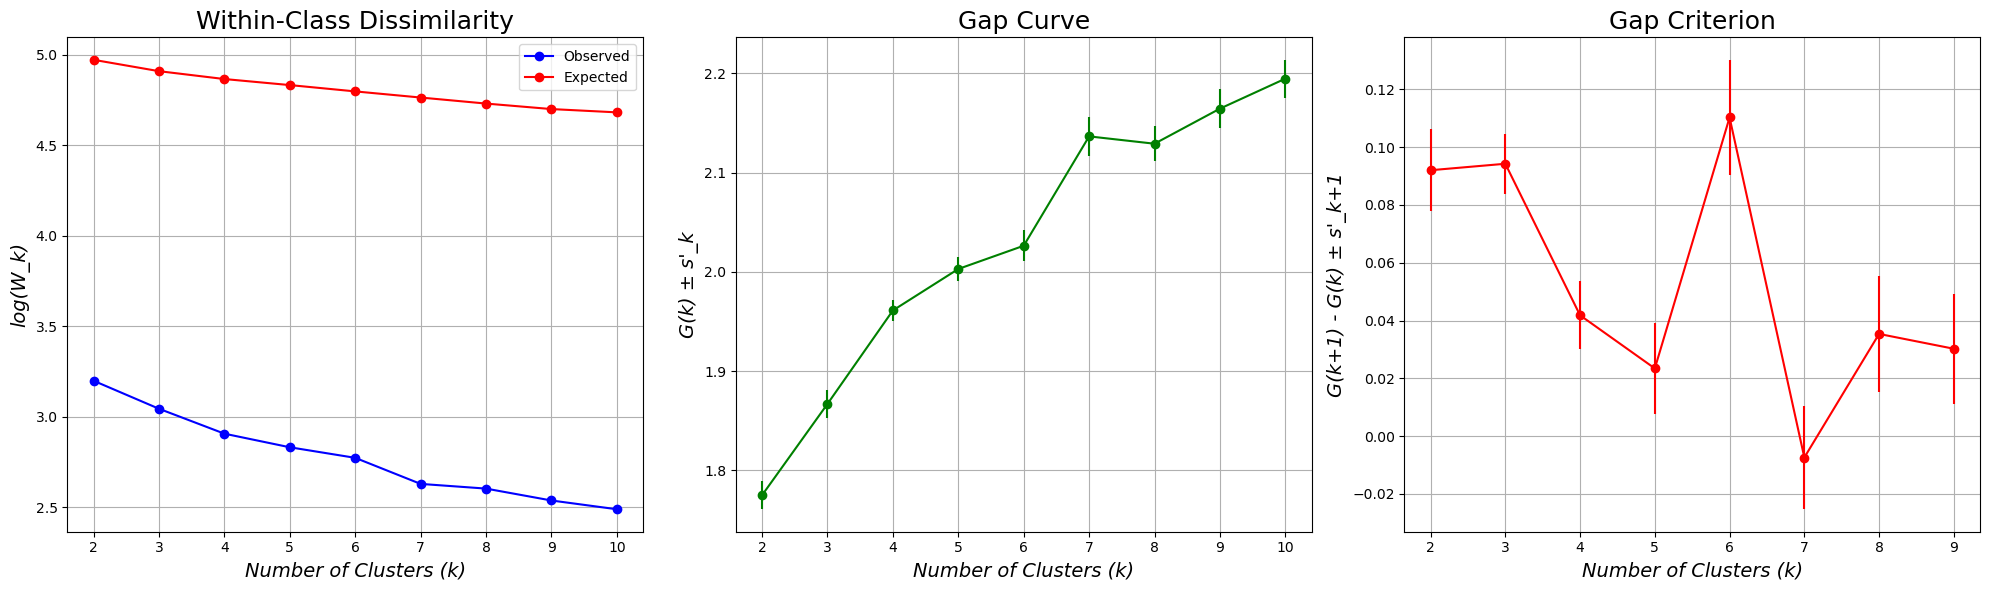

In [21]:
# Compute the gap statistics metrics
n_clusters = 10

(log_wk,
expected_log_wk,
gaps,
gap_diff,
s_k_ref,
s_prime_k) = gap_statistics(features, n_clusters, references = 20, random_state = rdst, model = KMeans())

# Set up figure
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Within-Class Dissimilarity
axes[0].plot(range(2, n_clusters+1), log_wk, marker = 'o', color = 'b', label = 'Observed')
axes[0].plot(range(2, n_clusters+1), expected_log_wk, marker = 'o', color = 'r', label = 'Expected')
axes[0].set_title('Within-Class Dissimilarity', size = 18)
axes[0].set_xlabel('Number of Clusters (k)', size = 14, fontstyle = 'italic')
axes[0].set_ylabel('log(W_k)', size = 14, fontstyle = 'italic')
axes[0].grid(True)
axes[0].legend()

# Plot 2: Gap Curve
axes[1].errorbar(range(2, n_clusters+1), gaps, yerr=s_prime_k, fmt='o-', color='g', label='Gap Statistic')
axes[1].set_title('Gap Curve', size = 18)
axes[1].set_xlabel('Number of Clusters (k)', size = 14, fontstyle = 'italic')
axes[1].set_ylabel('G(k) ± s\'_k', size = 14, fontstyle = 'italic')
axes[1].grid(True)

# Plot 3: Gap Criterion
axes[2].errorbar(range(2, n_clusters), gap_diff, yerr=s_prime_k[1:], fmt='o-', color='r', label='Gap Criterion')
axes[2].set_title('Gap Criterion', size = 18)
axes[2].set_xlabel('Number of Clusters (k)', size = 14, fontstyle = 'italic')
axes[2].set_ylabel('G(k+1) - G(k) ± s\'_k+1', size = 14, fontstyle = 'italic')
axes[2].grid(True)

plt.tight_layout()
plt.show()

### Clustering

<div class="alert alert-block alert-warning">
<b>To Do:</b> Decide on optimal number of clusters.
</div>

In [22]:
# Define optimal number of clusters and fit KMeans
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=rdst)
normalized_data['cluster_kmeans'] = kmeans.fit_predict(features)

# Print table of cluster mean center
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=features.columns)
cluster_centers.index = [f'Cluster {i+1}' for i in range(n_clusters)]
display(cluster_centers)

,HR_TD_Mean,HR_TD_Median,HR_TD_std,HR_TD_Min,HR_TD_Max,HR_TD_AUC,HR_TD_Kurtosis,HR_TD_Skew,HR_TD_Slope_min,HR_TD_Slope_max,HR_TD_Slope_mean,HR_TD_Slope
Cluster 1,0.141400,0.143483,0.113897,0.236188,0.122107,0.216556,0.104267,0.467297,0.901919,0.051403,0.547605,0.538792
Cluster 2,0.473466,0.410336,0.436168,0.494269,0.592745,0.508709,0.086792,0.470594,0.705087,0.123040,0.556739,0.553861
Cluster 3,0.275374,0.255150,0.135016,0.418795,0.252497,0.368288,0.102351,0.440616,0.900951,0.072910,0.590207,0.580255
Cluster 4,0.179281,0.128986,0.417863,0.193657,0.405491,0.283459,0.201756,0.651366,0.675912,0.117865,0.377374,0.363004


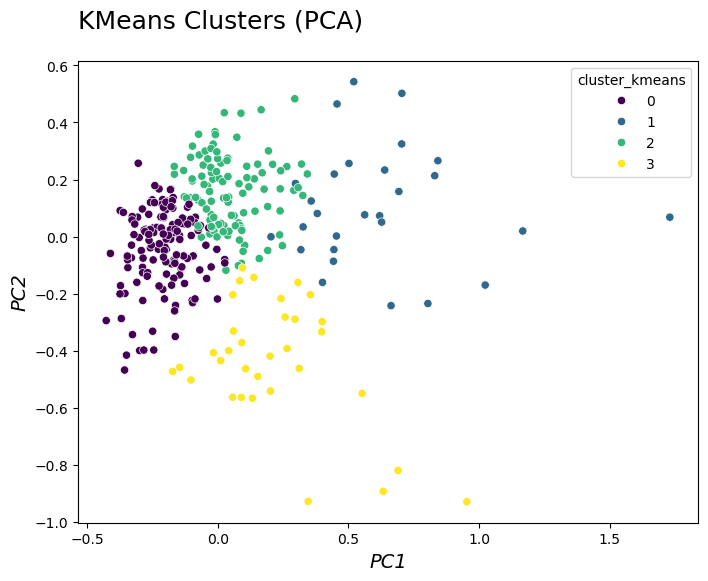

In [23]:
# Plot over principal components
fig, ax = plt.subplots(figsize=(8, 6))

ax = sn.scatterplot(data = normalized_data, x = 'PCA1', y = 'PCA2', hue = 'cluster_kmeans', palette = 'viridis')
ax.set_xlabel('PC1', size = 14, fontstyle = 'italic')
ax.set_ylabel('PC2', size = 14, fontstyle = 'italic')
ax.set_title('KMeans Clusters (PCA)', y=1.1, pad=-10, loc='left', size=18)

plt.show()

## Hierarchical

### Silhouette

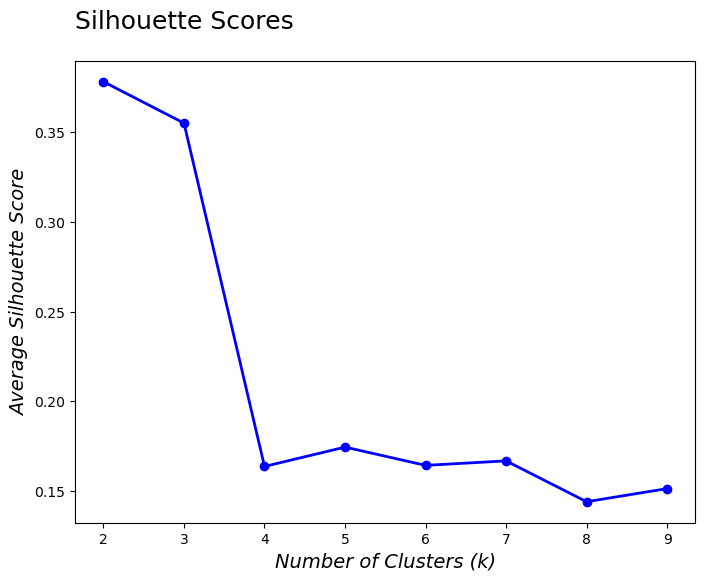

In [24]:
# Linkage matrix
Z = linkage(features, method='ward')

sil_scores = []
k_values = range(2, 10)

# Loop through k values
for k in k_values:
    labels = fcluster(Z, k, criterion='maxclust')
    score = silhouette_score(features, labels)
    sil_scores.append(score)

# Plot silhouette scores
fig, ax = plt.subplots(figsize=(8, 6))

ax = plt.plot(k_values, sil_scores, 'bo-', linewidth=2)
plt.ylabel("Average Silhouette Score", size = 14, fontstyle = 'italic')
plt.xlabel("Number of Clusters (k)", size = 14, fontstyle = 'italic')
plt.title('Silhouette Scores', y=1.1, pad=-10, loc='left', size=18)

plt.show()

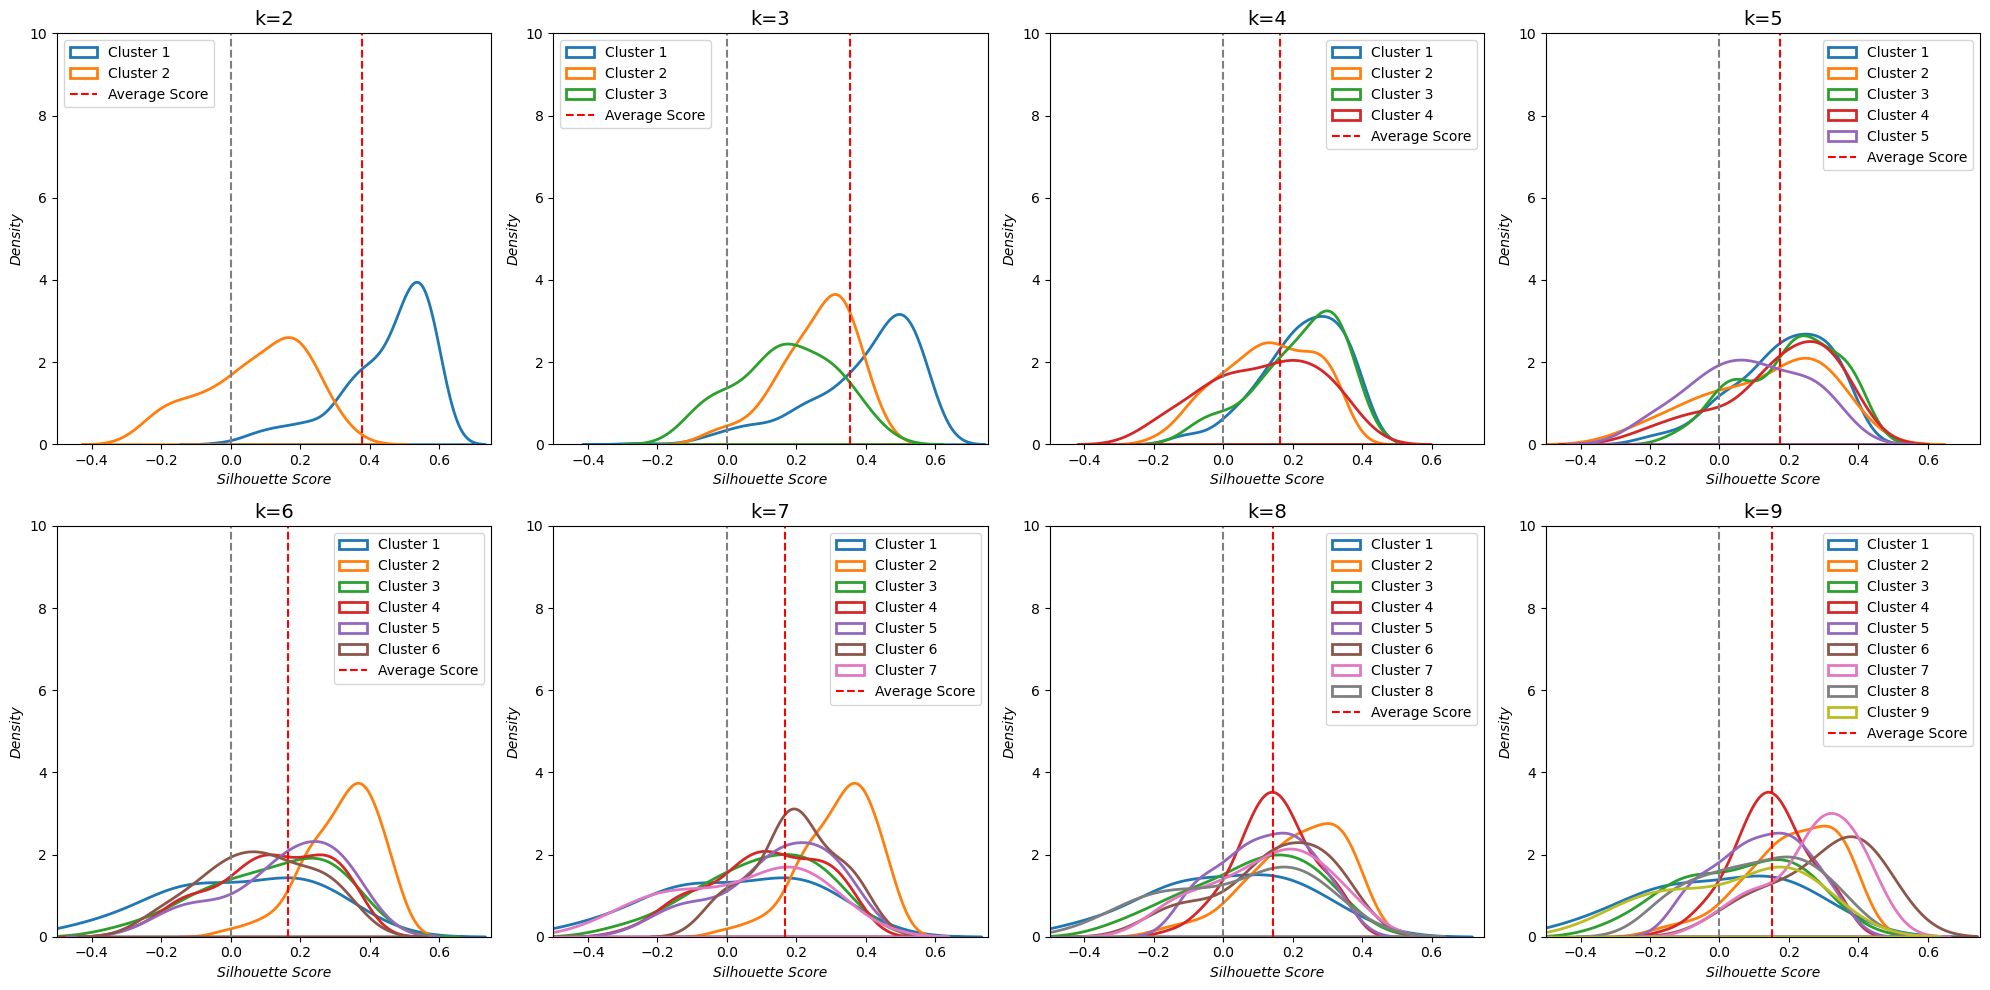

In [25]:
# Set up figure
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Loop through k values
for idx, k in enumerate(k_values):
    row, col = divmod(idx, 4)
    
    # Fit hierarchical model for k
    labels = fcluster(Z, k, criterion='maxclust') -1
    
    # Calculate silhouette scores
    sil_scores = silhouette_samples(features, labels)
    
    ax = axes[row, col]
    
    # Create separate density plots for each cluster
    for i in range(k):
        cluster_sil_scores = sil_scores[labels == i]
        sn.kdeplot(cluster_sil_scores, ax = ax, shade = True, alpha = 0, lw = 2, label = f'Cluster {i+1}')
    
    # Add average silhouette score
    avg_score = silhouette_score(features, labels)
    ax.axvline(x = avg_score, color = 'red', linestyle = '--', label = 'Average Score')

    # Add silhouette score = 0
    ax.axvline(x = 0, color = 'grey', linestyle = '--')
    
    ax.set_title(f'k={k}', size = 14)
    ax.set_xlim(-0.5, 0.75)
    ax.set_ylim(0, 10)
    ax.set_xlabel('Silhouette Score', size = 10, fontstyle = 'italic')
    ax.set_ylabel('Density', size = 10, fontstyle = 'italic')
    ax.legend()

plt.tight_layout()
plt.show()

### Gap statistics

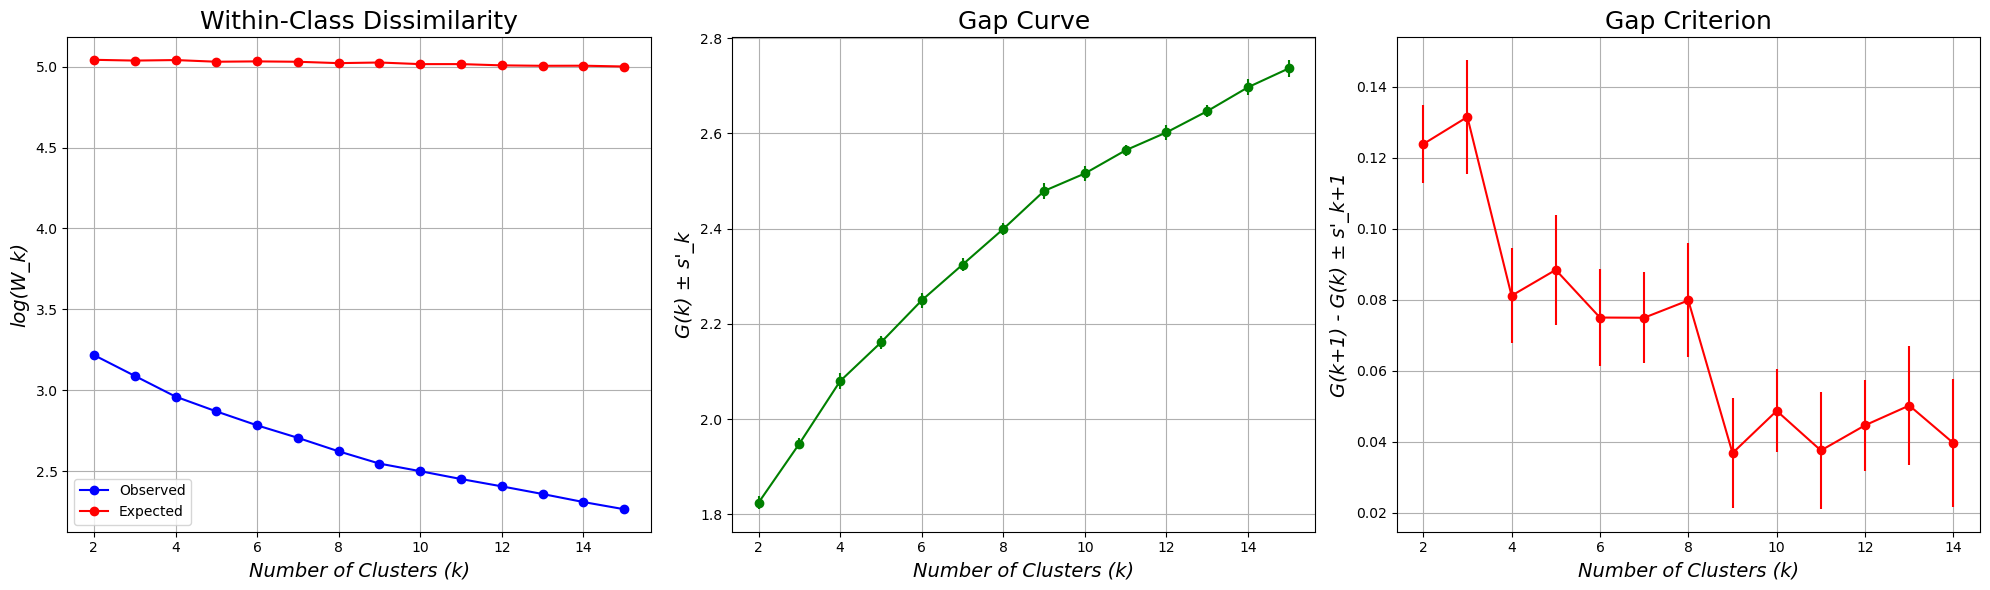

In [26]:
# Compute the gap statistics metrics
n_clusters = 15
hierach_model = HierarchicalModel(method = 'ward', criterion = 'maxclust')

(log_wk,
expected_log_wk,
gaps,
gap_diff,
s_k_ref,
s_prime_k) = gap_statistics(features, n_clusters, references = 20, random_state = rdst, model = hierach_model)

# Set up figure
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Within-Class Dissimilarity
axes[0].plot(range(2, n_clusters+1), log_wk, marker = 'o', color = 'b', label = 'Observed')
axes[0].plot(range(2, n_clusters+1), expected_log_wk, marker = 'o', color = 'r', label = 'Expected')
axes[0].set_title('Within-Class Dissimilarity', size = 18)
axes[0].set_xlabel('Number of Clusters (k)', size = 14, fontstyle = 'italic')
axes[0].set_ylabel('log(W_k)', size = 14, fontstyle = 'italic')
axes[0].grid(True)
axes[0].legend()

# Plot 2: Gap Curve
axes[1].errorbar(range(2, n_clusters+1), gaps, yerr=s_prime_k, fmt='o-', color='g', label='Gap Statistic')
axes[1].set_title('Gap Curve', size = 18)
axes[1].set_xlabel('Number of Clusters (k)', size = 14, fontstyle = 'italic')
axes[1].set_ylabel('G(k) ± s\'_k', size = 14, fontstyle = 'italic')
axes[1].grid(True)

# Plot 3: Gap Criterion
axes[2].errorbar(range(2, n_clusters), gap_diff, yerr=s_prime_k[1:], fmt='o-', color='r', label='Gap Criterion')
axes[2].set_title('Gap Criterion', size = 18)
axes[2].set_xlabel('Number of Clusters (k)', size = 14, fontstyle = 'italic')
axes[2].set_ylabel('G(k+1) - G(k) ± s\'_k+1', size = 14, fontstyle = 'italic')
axes[2].grid(True)

plt.tight_layout()
plt.show()

### Clustering

<div class="alert alert-block alert-warning">
<b>To Do:</b> Decide on optimal number of clusters.
</div>

[]

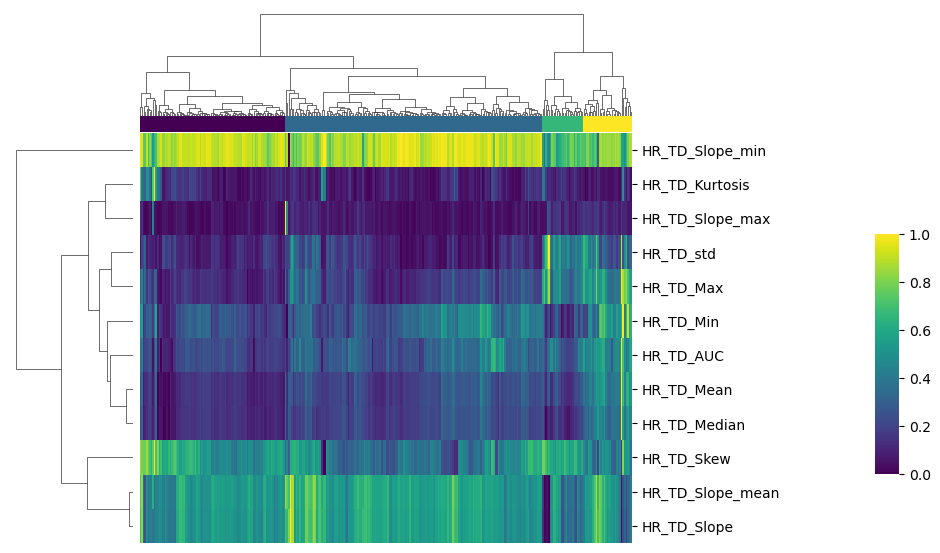

In [27]:
# Define optimal number of clusters and fit Hierarchical clustering
n_clusters = 4
labels = fcluster(Z, n_clusters, criterion = 'maxclust')
normalized_data['cluster_hierarch'] = labels

# Create a color array based on the labels (one color per cluster)
colors = [plt.cm.get_cmap('viridis', n_clusters) (label-1) for label in labels]

# Plot heatmap with dendrograms
ax_heatmap = sn.clustermap(features.T, cmap = 'viridis',
              col_linkage = Z, col_colors = colors, row_cluster = True,
              figsize = (8, 6), cbar_pos = (1.1, .2, .03, .4))
ax_heatmap.ax_heatmap.set_xticks([])

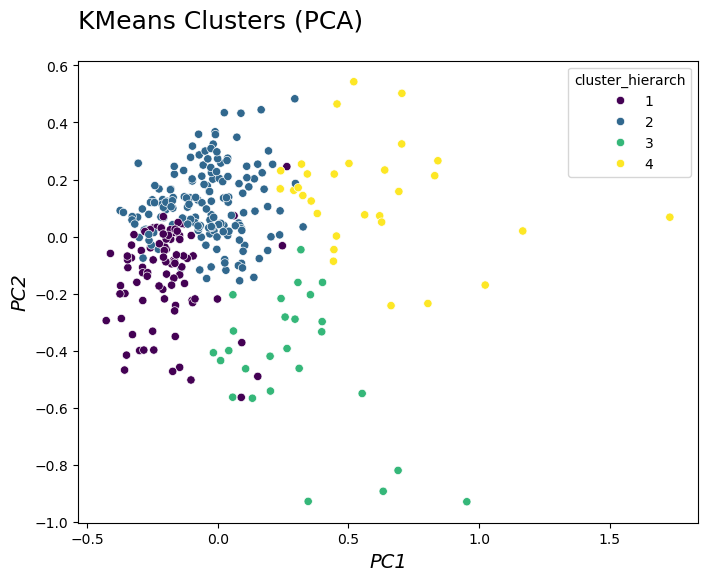

In [29]:
# Plot over principal components
fig, ax = plt.subplots(figsize=(8, 6))

ax = sn.scatterplot(data = normalized_data, x = 'PCA1', y = 'PCA2', hue = 'cluster_hierarch', palette = 'viridis')
ax.set_xlabel('PC1', size = 14, fontstyle = 'italic')
ax.set_ylabel('PC2', size = 14, fontstyle = 'italic')
ax.set_title('KMeans Clusters (PCA)', y=1.1, pad=-10, loc='left', size=18)

plt.show()

## Further exploration

<div class="alert alert-block alert-warning">
<b>To Do:</b> Change file name.
</div>

In [30]:
# Save dataframe to csv file
final_data = pd.concat([idx_data_cleaned, normalized_data], axis=1)
final_data.to_csv("results/eda_data.csv", index=False)

In [ ]:
kmeans_melted = pd.melt(normalized_data.reset_index(), 
                 id_vars='cluster_kmeans', 
                 value_vars=features.columns,
                 var_name='Question', value_name='Score')

plt.figure(figsize=(14, 6))
sn.boxplot(data = kmeans_melted, x = 'Question', y = 'Score', hue = 'cluster_kmeans')
plt.title("Distribution of Emotional States by Cluster (KMeans)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
hierarch_melted = pd.melt(normalized_data.reset_index(), 
                 id_vars='cluster_hierarch', 
                 value_vars=features.columns,
                 var_name='Question', value_name='Score')

plt.figure(figsize=(14, 6))
sn.boxplot(data = hierarch_melted, x = 'Question', y = 'Score', hue = 'cluster_hierarch')
plt.title("Distribution of Emotional States by Cluster (Hierarchical)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()